# BDA Project
- Romain Claret
- Jämes Ménétrey
- Damien Rochat

### Load PySpark

In [1]:
import os
import findspark
findspark.init()

import pyspark

#memory = '4g'
#pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["SPARK_HOME"] = "/opt/spark"
#os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

#--driver-maxResultSize 10g --executor-memory 4g

from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("bda-spark-c")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '4g')
        .set('spark.driver.memory', '4g')
        .set('spark.driver.maxResultSize', '4g'))
sc = SparkContext(conf=conf)

### Check config

In [2]:
sc._conf.getAll()

[('spark.app.id', 'local-1559758191256'),
 ('spark.driver.memory', '4g'),
 ('spark.rdd.compress', 'True'),
 ('spark.executor.memory', '4g'),
 ('spark.driver.port', '36773'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'rclaret.tic.heia-fr.ch'),
 ('spark.app.name', 'bda-spark-c'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.maxResultSize', '4g')]

### Check if Spark is working with a little PI calculation using monte carlo

In [3]:
import random
num_samples = 100000
def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1
count = sc.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)

3.146


### Load the Dataset

In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
def df_maker(file_path):
    return (sqlContext.read.format("csv")
                .option("delimiter", ",")
                .option("header", "true")
                .load(file_path)
                .drop("medallion")
                .drop(" hack_license")
                .drop("hack_license")
                .withColumnRenamed(" vendor_id", "vendor_id")
                .withColumnRenamed(" rate_code", "rate_code")
                .withColumnRenamed(" store_and_fwd_flag", "store_and_fwd_flag")
                .withColumnRenamed(" pickup_datetime", "pickup_datetime")
                .withColumnRenamed(" dropoff_datetime", "dropoff_datetime")
                .withColumnRenamed(" passenger_count", "passenger_count")
                .withColumnRenamed(" trip_time_in_secs", "trip_time_in_secs")
                .withColumnRenamed(" trip_distance", "trip_distance")
                .withColumnRenamed(" pickup_longitude", "pickup_longitude")
                .withColumnRenamed(" pickup_latitude", "pickup_latitude")
                .withColumnRenamed(" dropoff_longitude", "dropoff_longitude")
                .withColumnRenamed(" dropoff_latitude", "dropoff_latitude")
           )

### Filter the Dataset

In [20]:
ny_lat_min = 39.0
ny_lat_max = 42.0
ny_lon_min = -77.0
ny_lon_max = -70.0

def df_filter(df):
    return (df.withColumn('pickup_longitude', df['pickup_longitude'].cast('float')) #convert str to float
            .withColumn('pickup_latitude', df['pickup_latitude'].cast('float'))
            .withColumn('dropoff_longitude', df['dropoff_longitude'].cast('float'))
            .withColumn('dropoff_latitude', df['dropoff_latitude'].cast('float'))
            .withColumn('trip_distance', df['trip_distance'].cast('float'))
            #.filter(df.trip_distance<40.0) #filter out long distance, miles
            .filter(df.pickup_latitude<=ny_lat_max)
            .filter(df.pickup_latitude>=ny_lat_min)
            .filter(df.pickup_longitude<=ny_lon_max)
            .filter(df.pickup_longitude>=ny_lon_min)
            .na.drop() #removes rows with null
           )

#var sw = new mapboxgl.LngLat(-77, 35);
#var ne = new mapboxgl.LngLat(-70, 45);

### Create complete Dataframe from all Dataset files

In [7]:
path_trip = "datasets/trip_data/"
for idx,e in enumerate(os.listdir(path_trip)):
    print(e)
    if idx == 0:
        dff = df_filter(df_maker(path_trip+e))
    else:
        df = df_filter(df_maker(path_trip+e))
        dff=dff.union(df)
dff.show(2)

trip_data_9.csv
trip_data_2.csv
trip_data_11.csv
trip_data_7.csv
trip_data_5.csv
trip_data_4.csv
trip_data_1.csv
trip_data_8.csv
trip_data_10.csv
trip_data_12.csv
trip_data_6.csv
trip_data_3.csv
+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|      CMT|        1|                 N|2013-09-01 16:35:05|2013-09-01 16:47:53|              2|              767|          2.6|        -73.9879|       40.72408|         -73.9946|        40.75058|
|      CMT|      

#### Count of the whole dataset

In [25]:
dff.count()

85147405

#### Count of the unique last dataset load

In [26]:
df.count()

7774669

## Playing with a smaller dataset: 1/9
### Temporary Dataframes

### Serialization of the small dataframe

In [26]:
pd_df_pickle_path = "pickles/trip_data_3.pickle"
pd_df.to_pickle(pd_df_pickle_path)

pd_df_json_path = "json/trip_data_3_clusters.json"
pd_df.to_json(pd_df_json_path)

In [8]:
df_copy = df

## Using K-Means to show Clusters
- pickup cluster
- dropoff cluster

### Cluster fitter function

In [9]:
from pyspark.ml.feature import VectorAssembler
def calculate_kmeans_cluster(df, model, feature_1, feature_2, cluser_name):
    vecAssembler = VectorAssembler(inputCols=[feature_1, feature_2], outputCol="features")
    df_features = vecAssembler.transform(df)
    
    df = model.transform(df_features)
    
    df = df.withColumnRenamed('prediction', cluser_name)
    df = df.drop('features')
    return df

### K-Means model building function

In [18]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

def build_kmeans_model(df,k_n=2,iter_n=20,steps_n=5,tol_n=1e-4,feature_1,feature_2):
    vecAssembler = VectorAssembler(inputCols=[feature_1, feature_2], outputCol="features")
    vec_df = vecAssembler.transform(df)
    
    kmeans = KMeans(k=k_n, seed=1, maxIter=iter_n, initSteps=steps_n, tol=tol_n)
    
    model = kmeans.fit(vec_df.select('features'))
    return model

### Build K-Means Model with k = 15

In [36]:
df_model = build_kmeans_model(df_copy,k_n=15,feature_1="dropoff_latitude",feature_2="dropoff_longitude")

### Vecorizing and Clustering pickup clusters

In [37]:
df_copy = calculate_kmeans_cluster(df_copy, df_model, "pickup_latitude", "pickup_longitude", "pickup_cluster")

### Vecorizing and Clustering dropoff clusters

In [38]:
df_copy = calculate_kmeans_cluster(df_copy, df_model, "dropoff_latitude", "dropoff_longitude", "dropoff_cluster")

## Plotting
### Convert to Panda Dataframe

In [39]:
pd_df = df_copy.toPandas()

In [40]:
pd_df = pd_df.sample(frac=0.1)

### Santy check for the clusters
They should be the same shape

In [41]:
pd_df["pickup_cluster"].shape

(777467,)

In [42]:
pd_df["dropoff_cluster"].shape

(777467,)

### Serialization of the Custers from the small dataframe

In [66]:
import pandas as pd
def kmeans_centroid_to_json(model, path):
    centers = model.clusterCenters()
    centers_df = pd.DataFrame(centers, columns=["latitude","longitude"])
    
    centers_df = centers_df[(centers_df.longitude < ny_lon_max) &
                     (centers_df.longitude > ny_lon_min) &
                     (centers_df.latitude < ny_lat_max) &
                     (centers_df.latitude > ny_lat_min)
                    ]
    
    centers_df.to_json(path)
    print(centers_df_filtered)

In [45]:
kmeans_centroid_to_json(df_model,"json/trip_data_3_clusters.json")

     latitude   longitude
0   40.762053  -73.976415
1    0.000000    0.000000
2   40.718634  -74.007684
3  -13.058743  -70.017784
4   31.906618  -59.001765
5  -35.565784  110.037483
6   32.581437  -77.374125
7   49.184209  -85.095897
8   40.781436  -73.954977
9   40.674402  -73.968862
10  40.725376  -73.837258
11  40.729471  -73.981575
12  47.424091  -62.203171
13  40.747845  -73.993752
14  40.842352  -73.926069


### Seaborn
#### Show Pickup Cluster

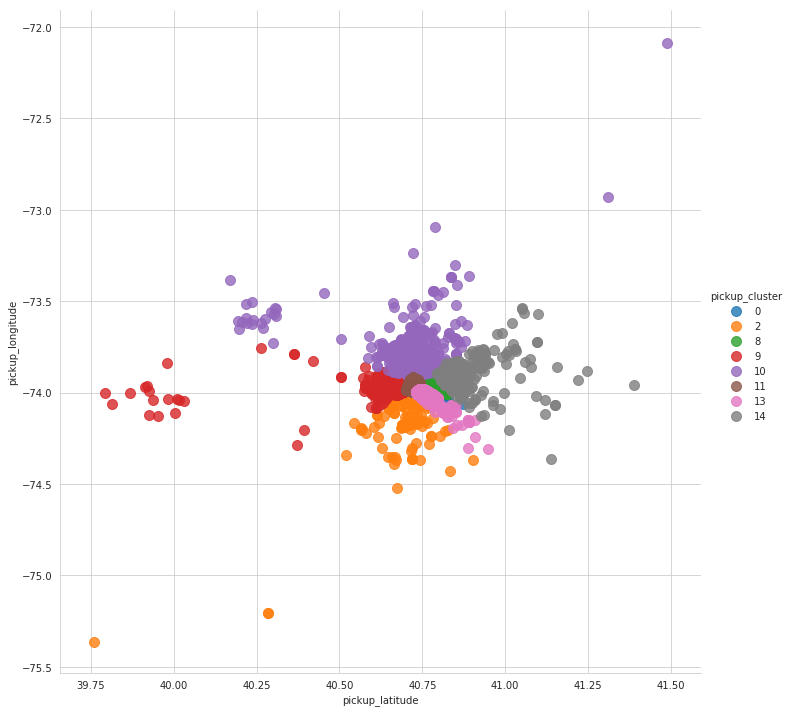

In [43]:
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.lmplot(x="pickup_longitude", y="pickup_latitude",data = pd_df[pd_df['pickup_latitude']!=0.0],fit_reg=False,hue='pickup_cluster',height=10,scatter_kws={"s":100})

#### Show Dropoff Clusters

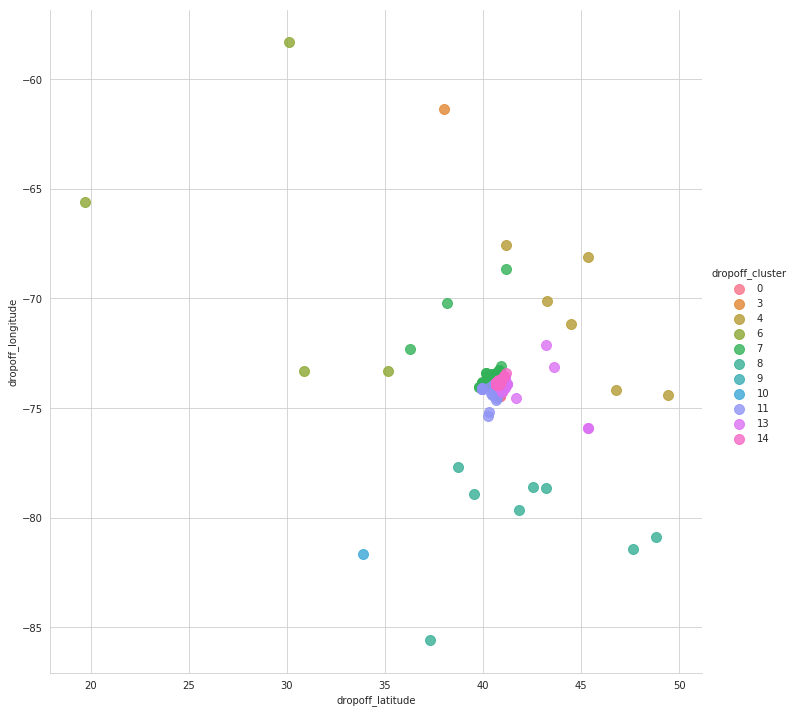

In [21]:
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.lmplot(x="dropoff_longitude", y="dropoff_latitude",data = pd_df[pd_df['dropoff_latitude']!=0.0],fit_reg=False,hue='dropoff_cluster',height=10,scatter_kws={"s":100})

### Build K-Means with k=8 and Plot Seaborn

In [ ]:
#def build_kmeans_model(df,k_n=2,iter_n=20,steps_n=5,tol_n=1e-4,feature_1,feature_2):
df_model = build_kmeans_model(df_copy,k_n=8,iter_n=50,
                              steps_n=20,tol_n=1.0E-5,
                              feature_1="dropoff_latitude",feature_2="dropoff_longitude")
df_copy = calculate_kmeans_cluster(df_copy, df_model, "pickup_latitude", "pickup_longitude", "pickup_cluster")
df_copy = calculate_kmeans_cluster(df_copy, df_model, "dropoff_latitude", "dropoff_longitude", "dropoff_cluster")

kmeans_centroid_to_json(df_model,"json/trip_data_3_clusters_k8.json")

In [ ]:
pd_df = df_copy.toPandas()
pd_df = pd_df.sample(frac=0.1)

In [ ]:
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.lmplot(x="pickup_longitude", y="pickup_latitude",data = pd_df[pd_df['pickup_latitude']!=0.0],fit_reg=False,hue='pickup_cluster',height=10,scatter_kws={"s":100})

## Playing with the full dataset

In [27]:
dff_copy = dff

In [29]:
dff_model = build_kmeans_model(dff_copy,"dropoff_latitude","dropoff_longitude")

dff_copy = calculate_kmeans_cluster(dff_copy, dff_model, "pickup_latitude", "pickup_longitude", "pickup_cluster")
dff_copy = calculate_kmeans_cluster(dff_copy, dff_model, "dropoff_latitude", "dropoff_longitude", "dropoff_cluster")

In [50]:
kmeans_centroid_to_json(dff_model,"json/trip_data_all_clusters.json")

     latitude   longitude
0   40.772201  -73.967465
1   -0.000019    0.000009
2  -81.171123   55.801757
3    8.749112  123.012612
4   30.091913  -74.007802
5   40.730842  -73.991855
6  -30.462790 -140.638888
7   52.740814 -122.077444
8    1.262239  -87.893747
9   59.126598   76.873234
10  43.631720  -85.202529
11 -11.302133  -45.167694
12  51.750503  -22.021760
13  40.730309  -73.844112
14  45.412202  -64.029740


In [51]:
pd_dff = dff_copy.toPandas()
pd_dff = pd_dff.sample(frac=0.1)

Py4JJavaError: An error occurred while calling o905.collectToPython.
: org.apache.spark.SparkException: Job 74 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:932)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:930)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:930)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:2128)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2041)
	at org.apache.spark.SparkContext.$anonfun$stop$10(SparkContext.scala:1949)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1340)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1949)
	at org.apache.spark.SparkContext.$anonfun$new$30(SparkContext.scala:575)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:216)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$2(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1945)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$1(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at org.apache.hadoop.util.ShutdownHookManager$1.run(ShutdownHookManager.java:54)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3257)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3254)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 46022)
Traceback (most recent call last):
  File "/home/rclaret/anaconda3/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/rclaret/anaconda3/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/home/rclaret/anaconda3/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/rclaret/anaconda3/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/opt/spark/python/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/opt/spark/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/opt/spark/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  

### Seaborn
#### Show Pickup Cluster

In [ ]:
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.lmplot(x="dropoff_latitude", y="dropoff_longitude",data = pd_dff[pd_dff['dropoff_latitude']!=0.0],fit_reg=False,hue='dropoff_cluster',height=10,scatter_kws={"s":100})

#### Show Dropoff Cluster

In [ ]:
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.lmplot(x="dropoff_latitude", y="dropoff_longitude",data = pd_dff[pd_dff['dropoff_latitude']!=0.0],fit_reg=False,hue='dropoff_cluster',height=10,scatter_kws={"s":100})

### Serialization of the small dataframe

In [26]:
pd_df_pickle_path = "pickles/trip_data_3.pickle"
pd_df.to_pickle(pd_df_pickle_path)

pd_df_json_path = "json/trip_data_3_clusters.json"
pd_df.to_json(pd_df_json_path)